Training model for new listings without price history...
Loading data...
Removing 12 price history features: ['price_lag_1d', 'price_lag_7d', 'price_lag_30d', 'rolling_mean_7d', 'rolling_max_7d', 'rolling_min_7d', 'rolling_mean_14d', 'rolling_max_14d', 'rolling_min_14d', 'rolling_mean_30d', 'rolling_max_30d', 'rolling_min_30d']
Creating features for new listings...
Selecting most important features...
Selected 30 top features:
1. knn_price_mean
2. knn_price_median
3. neigh_price_median
4. has_bed_linens
5. DTF_season_sin
6. bedrooms
7. DTF_day_of_week
8. neigh_price_per_accommodates
9. has_heating
10. accommodates
... and 20 more
Training XGBoost model...
[0]	validation_0-rmse:0.90332
[100]	validation_0-rmse:0.42481
[200]	validation_0-rmse:0.27983
[300]	validation_0-rmse:0.24169
[400]	validation_0-rmse:0.23411
[459]	validation_0-rmse:0.23376
Making predictions...

--- Model Performance Metrics ---
RMSE: 0.2335
MAE: 0.1068
R²: 0.9343
MAPE: 57.27%
Model saved to C:\Users\mvk\Documents\DA

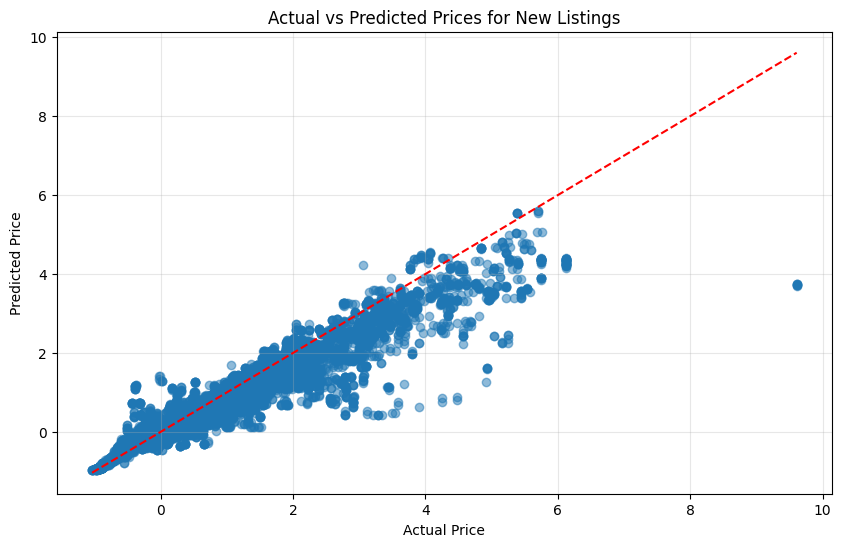

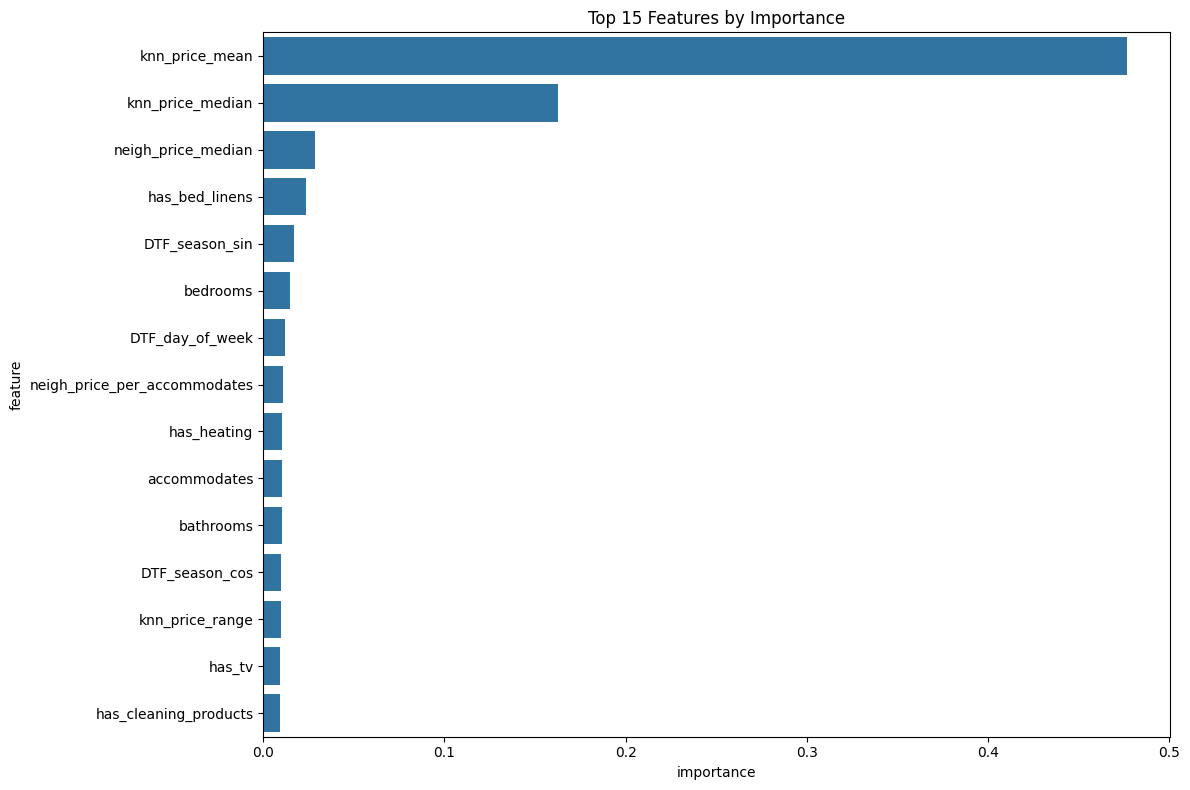

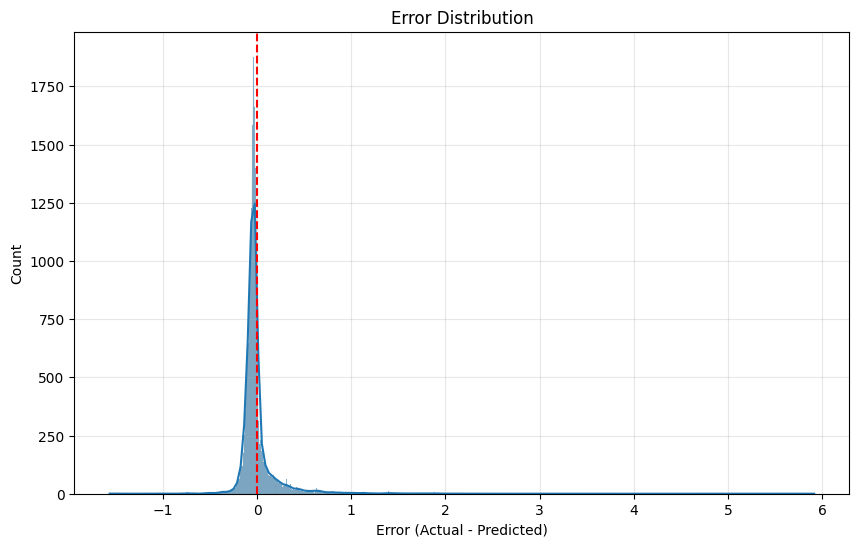


Model for new listings (without price history):
  rmse: 0.233457
  mae: 0.106842
  r2: 0.934281
  mape: 57.265651

Example prediction for a new listing:
Reducing k_neighbors from 5 to 0 due to small sample size
Predicted price for new listing: 0.10


In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import BallTree
from joblib import Parallel, delayed
import math
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def create_spatial_features(df, k_neighbors=5, chunk_size=1000, n_jobs=-1):
    """Enhanced spatial features for new listings"""
    # Adjust k_neighbors if the dataset is small
    actual_k = min(k_neighbors, len(df) - 1)
    if actual_k < k_neighbors:
        print(f"Reducing k_neighbors from {k_neighbors} to {actual_k} due to small sample size")
    
    city_center_lat, city_center_lon = 48.8566, 2.3522  # Paris coordinates
    
    # Initialize spatial features dictionary
    spatial_data = {
        'distance_to_center': [],
        'north_south': [],
        'east_west': [],
        'knn_price_mean': [],
        'knn_price_std': [],
        'knn_price_median': [],
        'knn_price_range': [],
        'distance_weighted_price': []
    }
    
    # Calculate basic distance features
    spatial_data['distance_to_center'] = df.apply(
        lambda row: calculate_distance(
            row['latitude'], 
            row['longitude'], 
            city_center_lat, 
            city_center_lon
        ),
        axis=1
    ).values
    
    spatial_data['north_south'] = (df['latitude'] - city_center_lat).values
    spatial_data['east_west'] = (df['longitude'] - city_center_lon).values
    
    # Enhanced BallTree processing
    all_coords = np.radians(df[['latitude', 'longitude']].values)
    tree = BallTree(all_coords, metric='haversine')
    all_prices = df['price'].values if 'price' in df.columns else np.zeros(len(df))
    
    def enhanced_process_chunk(chunk_data, tree, k_neighbors, all_prices):
        """Process chunk for spatial features"""
        coords = np.radians(chunk_data[['latitude', 'longitude']].values)
        # Use adaptive k value
        k_query = min(k_neighbors + 1, len(all_coords))
        distances, indices = tree.query(coords, k=k_query)
        
        # If k_query is 1, handle special case
        if k_query == 1:
            n_samples = len(chunk_data)
            return {
                'knn_price_mean': np.zeros(n_samples),
                'knn_price_std': np.zeros(n_samples),
                'knn_price_median': np.zeros(n_samples),
                'knn_price_range': np.zeros(n_samples),
                'distance_weighted_price': np.zeros(n_samples)
            }
        
        # Process neighbor data
        if k_query == 2:
            neighbor_prices = np.take(all_prices, indices[:, 1:]).reshape(-1, 1)
            weights = np.ones((len(distances), 1))
        else:
            weights = 1 / (distances[:, 1:] + 1e-6)
            weights = weights / weights.sum(axis=1, keepdims=True)
            neighbor_prices = np.take(all_prices, indices[:, 1:])
        
        # Calculate neighbor statistics
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            mean_prices = np.nanmean(neighbor_prices, axis=1)
            std_prices = np.nanstd(neighbor_prices, axis=1)
            
            if neighbor_prices.shape[1] == 1:
                median_prices = neighbor_prices.flatten()
                range_prices = np.zeros(len(neighbor_prices))
            else:
                median_prices = np.nanmedian(neighbor_prices, axis=1)
                range_prices = np.ptp(neighbor_prices, axis=1)
            
            if neighbor_prices.shape[1] == 1:
                weighted_prices = neighbor_prices.flatten()
            else:
                weighted_prices = np.sum(weights * neighbor_prices, axis=1)
        
        return {
            'knn_price_mean': mean_prices,
            'knn_price_std': std_prices,
            'knn_price_median': median_prices,
            'knn_price_range': range_prices,
            'distance_weighted_price': weighted_prices
        }
    
    # Split and process chunks
    n_chunks = math.ceil(len(df) / chunk_size)
    chunks = np.array_split(df, n_chunks)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(enhanced_process_chunk)(
            chunk, 
            tree, 
            actual_k,
            all_prices
        ) for chunk in chunks
    )
    
    # Combine results
    for key in spatial_data.keys():
        if key not in ['distance_to_center', 'north_south', 'east_west']:
            spatial_data[key] = np.concatenate([r[key] for r in results])
    
    spatial_features = pd.DataFrame(spatial_data, index=df.index)
    
    # Standardize features
    features_to_standardize = list(spatial_data.keys())
    
    for col in features_to_standardize:
        mean_val = spatial_features[col].mean()
        std_val = spatial_features[col].std()
        if std_val > 0:
            spatial_features[col] = (spatial_features[col] - mean_val) / std_val
        else:
            spatial_features[col] = 0
    
    return spatial_features

def create_temporal_features(df):
    """Create enhanced temporal features for new listings"""
    # Make a copy of the dataframe to avoid modifying the original
    result = df.copy()
    
    # Convert date column to datetime
    if 'date' in result.columns and not pd.api.types.is_datetime64_any_dtype(result['date']):
        result['date'] = pd.to_datetime(result['date'])
    
    # Extract basic temporal features
    result['day_of_week'] = result['date'].dt.dayofweek
    result['month'] = result['date'].dt.month
    result['day_of_month'] = result['date'].dt.day
    result['is_weekend'] = result['day_of_week'].isin([5, 6]).astype(int)
    
    # Create season features using sine and cosine to capture cyclical nature
    # Days since start of year normalized to 0-1
    day_of_year = result['date'].dt.dayofyear
    year_length = 365.25
    result['season_sin'] = np.sin(2 * np.pi * day_of_year / year_length)
    result['season_cos'] = np.cos(2 * np.pi * day_of_year / year_length)
    
    # Create holiday proximity feature (consider main holidays)
    holidays = [
        # Format: 'MM-DD' for recurring yearly holidays
        '01-01',  # New Year's Day
        '05-01',  # Labor Day
        '07-14',  # Bastille Day
        '08-15',  # Assumption Day
        '11-01',  # All Saints' Day
        '11-11',  # Armistice Day
        '12-25',  # Christmas
    ]
    
    # Create date strings for comparison
    result['date_mmdd'] = result['date'].dt.strftime('%m-%d')
    
    # Initialize holiday proximity
    result['is_holiday'] = result['date_mmdd'].isin(holidays).astype(int)
    
    # Calculate proximity to holidays (minimum days to closest holiday)
    def days_to_closest_holiday(date_str, holiday_list):
        mm_dd = datetime.strptime(date_str, '%m-%d')
        min_days = 183  # Half a year (maximum possible distance)
        
        for holiday in holiday_list:
            h_month, h_day = map(int, holiday.split('-'))
            h_date = mm_dd.replace(month=h_month, day=h_day)
            
            # Calculate days difference considering year wrap-around
            days_diff = abs((h_date - mm_dd).days)
            if days_diff > 183:  # If we crossed year boundary, calculate the other way
                days_diff = 365 - days_diff
            
            min_days = min(min_days, days_diff)
        
        return min_days
    
    result['holiday_proximity'] = result['date_mmdd'].apply(
        lambda x: days_to_closest_holiday(x, holidays)
    )
    
    # Normalize holiday proximity to 0-1 range
    max_proximity = result['holiday_proximity'].max()
    if max_proximity > 0:
        result['holiday_proximity'] = 1 - (result['holiday_proximity'] / max_proximity)
    
    # Drop temporary columns
    result.drop(['date_mmdd'], axis=1, inplace=True)
    
    return result

def add_amenities_score(df):
    """Calculate an amenity score and premium amenity count"""
    # Identify amenity columns
    amenity_cols = [col for col in df.columns if col.startswith('has_')]
    
    if not amenity_cols:
        print("Warning: No amenity columns found starting with 'has_'")
        return df
    
    # Make a copy of the dataframe
    result = df.copy()
    
    # Calculate total amenity score
    result['amenity_count'] = result[amenity_cols].sum(axis=1)
    
    # Calculate normalized amenity score (0-1)
    max_amenities = len(amenity_cols)
    result['amenity_score'] = result['amenity_count'] / max_amenities
    
    # Identify premium amenities that might command higher prices
    premium_amenities = [
        'has_kitchen', 'has_wifi', 'has_dedicated_workspace', 'has_washer', 
        'has_tv', 'has_heating', 'has_refrigerator'
    ]
    
    # Filter to only include premium amenities that exist in the dataframe
    premium_amenities = [col for col in premium_amenities if col in amenity_cols]
    
    if premium_amenities:
        result['premium_amenity_count'] = result[premium_amenities].sum(axis=1)
        result['premium_amenity_score'] = result['premium_amenity_count'] / len(premium_amenities)
    
    return result

def create_neighborhood_features(df, neighborhood_col='neighbourhood_cleansed_encoded'):
    """Add neighborhood-based features"""
    # Check if neighborhood column exists
    if neighborhood_col not in df.columns:
        print(f"Warning: Neighborhood column '{neighborhood_col}' not found")
        return df
    
    # Make a copy of the dataframe
    result = df.copy()
    
    # Calculate neighborhood statistics if price column exists
    if 'price' in df.columns:
        # Group by neighborhood
        neighborhood_stats = df.groupby(neighborhood_col).agg({
            'price': ['mean', 'median', 'std', 'count'],
            'accommodates': 'mean',
            'bedrooms': 'mean'
        })
        
        # Flatten column names
        neighborhood_stats.columns = ['_'.join(col).strip('_') for col in neighborhood_stats.columns.values]
        
        # Join back to original dataframe
        for col in neighborhood_stats.columns:
            result[f'neigh_{col}'] = result[neighborhood_col].map(neighborhood_stats[col])
        
        # Calculate price per accommodates/bedrooms by neighborhood
        if 'accommodates' in df.columns:
            neighborhood_stats['price_per_accommodates'] = neighborhood_stats['price_mean'] / neighborhood_stats['accommodates_mean']
            result['neigh_price_per_accommodates'] = result[neighborhood_col].map(neighborhood_stats['price_per_accommodates'])
        
        if 'bedrooms' in df.columns:
            # Handle division by zero
            neighborhood_stats['bedrooms_mean'] = neighborhood_stats['bedrooms_mean'].replace(0, np.nan)
            neighborhood_stats['price_per_bedroom'] = neighborhood_stats['price_mean'] / neighborhood_stats['bedrooms_mean']
            result['neigh_price_per_bedroom'] = result[neighborhood_col].map(neighborhood_stats['price_per_bedroom'])
    
    return result

def feature_selection(X_train, y_train, top_n=20):
    """Select top features using XGBoost feature importance"""
    # Train a quick model to get feature importance
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # Get feature importance
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # Select top features
    top_features = feature_importance.head(top_n)['feature'].tolist()
    
    return top_features, feature_importance

def train_new_listing_model(train_data_path, test_data_path, output_dir=None):
    """
    Train a model for predicting prices of new listings without price history
    
    Parameters:
    -----------
    train_data_path: str
        Path to training data CSV
    test_data_path: str
        Path to test data CSV
    output_dir: str, optional
        Directory to save model and results
    
    Returns:
    --------
    dict
        Dictionary containing model, evaluation metrics, and predictions
    """
    print("Training model for new listings without price history...")
    
    # 1. Load and prepare data
    print("Loading data...")
    train_data = pd.read_csv(train_data_path)
    test_data = pd.read_csv(test_data_path)
    
    # Create copies to avoid modifying original data
    train_df = train_data.copy()
    test_df = test_data.copy()
    
    # Convert date to datetime
    train_df['date'] = pd.to_datetime(train_df['date'])
    test_df['date'] = pd.to_datetime(test_df['date'])
    
    # 2. Identify and remove price history features - we won't use these for new listings
    price_history_cols = [col for col in train_df.columns if any(x in col for x in ['lag', 'rolling'])]
    print(f"Removing {len(price_history_cols)} price history features: {price_history_cols}")
    
    train_df = train_df.drop(price_history_cols, axis=1)
    test_df = test_df.drop(price_history_cols, axis=1)
    
    # 3. Feature engineering specifically for new listings
    print("Creating features for new listings...")
    
    # 3.1 Enhance temporal features
    train_df = create_temporal_features(train_df)
    test_df = create_temporal_features(test_df)
    
    # 3.2 Create spatial features
    train_spatial = create_spatial_features(train_df)
    test_spatial = create_spatial_features(test_df)
    
    # 3.3 Add amenities score
    train_df = add_amenities_score(train_df)
    test_df = add_amenities_score(test_df)
    
    # 3.4 Add neighborhood features 
    train_df = create_neighborhood_features(train_df)
    test_df = create_neighborhood_features(test_df)
    
    # 3.5 Combine all features
    train_df = pd.concat([train_df, train_spatial], axis=1)
    test_df = pd.concat([test_df, test_spatial], axis=1)
    
    # 4. Prepare features and target
    # Exclude non-feature columns
    excluded_cols = ['listing_id', 'date', 'price']
    feature_cols = [col for col in train_df.columns if col not in excluded_cols]
    
    X_train = train_df[feature_cols]
    y_train = train_df['price']
    X_test = test_df[feature_cols]
    y_test = test_df['price']
    
    # 5. Feature selection to reduce dimensionality and improve model
    print("Selecting most important features...")
    top_features, feature_importance = feature_selection(X_train, y_train, top_n=30)
    
    print(f"Selected {len(top_features)} top features:")
    for i, feature in enumerate(top_features[:10], 1):
        print(f"{i}. {feature}")
    
    if len(top_features) > 10:
        print(f"... and {len(top_features) - 10} more")
    
    # Use only selected features
    X_train = X_train[top_features]
    X_test = X_test[top_features]
    
    # 6. Initialize and train model
    print("Training XGBoost model...")
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=6,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping_rounds=20,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1
    )
    
    # Train with early stopping
    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=100
    )
    
    # 7. Make predictions
    print("Making predictions...")
    y_pred = model.predict(X_test)
    
    # 8. Evaluate model
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
        'mape': np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
    }
    
    print("\n--- Model Performance Metrics ---")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"R²: {metrics['r2']:.4f}")
    print(f"MAPE: {metrics['mape']:.2f}%")
    
    # 9. Create results dataframe
    results_df = pd.DataFrame({
        'listing_id': test_df['listing_id'],
        'date': test_df['date'],
        'price': y_test,
        'predicted': y_pred,
        'error': y_test - y_pred,
        'abs_error': np.abs(y_test - y_pred),
        'pct_error': np.abs((y_test - y_pred) / (y_test + 1e-8)) * 100
    })
    
    if 'latitude' in test_df.columns and 'longitude' in test_df.columns:
        results_df['latitude'] = test_df['latitude']
        results_df['longitude'] = test_df['longitude']
    
    # 10. Save results if output directory is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        
        # Save model
        model_path = os.path.join(output_dir, 'new_listing_model.json')
        model.save_model(model_path)
        print(f"Model saved to {model_path}")
        
        # Save results
        results_path = os.path.join(output_dir, 'new_listing_predictions.csv')
        results_df.to_csv(results_path, index=False)
        print(f"Predictions saved to {results_path}")
        
        # Save feature importance
        importance_path = os.path.join(output_dir, 'feature_importance.csv')
        feature_importance.to_csv(importance_path, index=False)
        print(f"Feature importance saved to {importance_path}")
        
        # Save summary metrics
        with open(os.path.join(output_dir, 'model_summary.txt'), 'w') as f:
            f.write("New Listing XGBoost Model Summary\n")
            f.write("===============================\n\n")
            f.write("Performance Metrics:\n")
            for metric, value in metrics.items():
                f.write(f"  {metric}: {value:.6f}\n")
            
            f.write("\nTop 10 Features:\n")
            for i, row in feature_importance.head(10).iterrows():
                f.write(f"  {row['feature']}: {row['importance']:.6f}\n")
            
            f.write(f"\nTotal features used: {len(top_features)}\n")
            f.write(f"Total features available: {len(feature_cols)}\n")
            f.write(f"Price history features excluded: {len(price_history_cols)}\n")
    
    # 11. Create and display visualizations
    # Actual vs Predicted scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted Prices for New Listings')
    plt.grid(True, alpha=0.3)
    
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'actual_vs_predicted.png'), dpi=300)
    plt.show()
    
    # Feature importance plot
    plt.figure(figsize=(12, 8))
    top_n_features = feature_importance.head(15)
    sns.barplot(x='importance', y='feature', data=top_n_features)
    plt.title('Top 15 Features by Importance')
    plt.tight_layout()
    
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'feature_importance.png'), dpi=300)
    plt.show()
    
    # Error distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(results_df['error'], kde=True)
    plt.axvline(0, color='r', linestyle='--')
    plt.title('Error Distribution')
    plt.xlabel('Error (Actual - Predicted)')
    plt.grid(True, alpha=0.3)
    
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'error_distribution.png'), dpi=300)
    plt.show()
    
    return {
        'model': model,
        'metrics': metrics,
        'top_features': top_features,
        'feature_importance': feature_importance,
        'results': results_df
    }

def predict_new_listing_price(model, listing_data, top_features):
    """
    Predict price for a single new listing
    
    Parameters:
    -----------
    model: XGBRegressor
        Trained model
    listing_data: dict
        Dictionary containing listing features
    top_features: list
        List of feature names used by the model
    
    Returns:
    --------
    float
        Predicted price
    """
    # Convert listing data to DataFrame
    listing_df = pd.DataFrame([listing_data])
    
    # Create required features
    if 'date' in listing_df.columns:
        listing_df = create_temporal_features(listing_df)
    
    # Create spatial features if coordinates are available
    if 'latitude' in listing_df.columns and 'longitude' in listing_df.columns:
        spatial_features = create_spatial_features(listing_df)
        listing_df = pd.concat([listing_df, spatial_features], axis=1)
    
    # Add amenities score
    listing_df = add_amenities_score(listing_df)
    
    # Add neighborhood features (if possible)
    if 'neighbourhood_cleansed_encoded' in listing_df.columns:
        listing_df = create_neighborhood_features(listing_df)
    
    # Select only features used by the model
    available_features = [col for col in top_features if col in listing_df.columns]
    missing_features = set(top_features) - set(available_features)
    
    if missing_features:
        print(f"Warning: Missing {len(missing_features)} features: {missing_features}")
        # For missing features, fill with zeros
        for feature in missing_features:
            listing_df[feature] = 0
    
    # Make prediction
    X = listing_df[top_features]
    predicted_price = model.predict(X)[0]
    
    return predicted_price

def load_new_listing_model(model_path, feature_importance_path):
    """
    Load a trained model for new listings
    
    Parameters:
    -----------
    model_path: str
        Path to saved model file
    feature_importance_path: str
        Path to feature importance CSV
    
    Returns:
    --------
    tuple
        (model, top_features)
    """
    # Load model
    model = XGBRegressor()
    model.load_model(model_path)
    
    # Load feature importance to get top features
    feature_importance = pd.read_csv(feature_importance_path)
    top_features = feature_importance['feature'].tolist()
    
    return model, top_features

if __name__ == "__main__":
    # Example usage
    train_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train.csv"
    test_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\test_feb.csv"
    output_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\NewListings"
    
    # Train model and get results
    results = train_new_listing_model(train_path, test_path, output_dir)
    
    # Compare against STRAP or XGBoost with price history
    print("\nModel for new listings (without price history):")
    for metric, value in results['metrics'].items():
        print(f"  {metric}: {value:.6f}")
    
    # Example of how to predict for a new listing
    print("\nExample prediction for a new listing:")
    # Create a sample new listing (you'd get this from real data)
    new_listing = {
        'listing_id': 999999,
        'date': '2023-02-15',
        'latitude': 48.8566,
        'longitude': 2.3522,
        'accommodates': 2,
        'bedrooms': 1,
        'has_kitchen': 1,
        'has_wifi': 1,
        'has_tv': 0,
        'neighbourhood_cleansed_encoded': 2,
        # Add other required features
    }
    
    # Predict price
    predicted_price = predict_new_listing_price(
        results['model'], 
        new_listing, 
        results['top_features']
    )
    
    print(f"Predicted price for new listing: {predicted_price:.2f}")

In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import BallTree
from joblib import Parallel, delayed
import math
from statsmodels.tsa.stattools import acf
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def calculate_error_autocorrelation(errors, max_lag=7):
    """Calculate autocorrelation of prediction errors"""
    # Calculate autocorrelation
    error_acf = acf(errors, nlags=max_lag)
    
    # Return values excluding lag 0 (which is always 1)
    return error_acf[1:]

def create_spatial_features(df, k_neighbors=5, chunk_size=1000, n_jobs=-1):
    """Enhanced spatial features for new listings"""
    # Adjust k_neighbors if the dataset is small
    actual_k = min(k_neighbors, len(df) - 1)
    if actual_k < k_neighbors:
        print(f"Reducing k_neighbors from {k_neighbors} to {actual_k} due to small sample size")
    
    city_center_lat, city_center_lon = 48.8566, 2.3522  # Paris coordinates
    
    # Initialize spatial features dictionary
    spatial_data = {
        'distance_to_center': [],
        'north_south': [],
        'east_west': [],
        'knn_price_mean': [],
        'knn_price_std': [],
        'knn_price_median': [],
        'knn_price_range': [],
        'distance_weighted_price': []
    }
    
    # Calculate basic distance features
    spatial_data['distance_to_center'] = df.apply(
        lambda row: calculate_distance(
            row['latitude'], 
            row['longitude'], 
            city_center_lat, 
            city_center_lon
        ),
        axis=1
    ).values
    
    spatial_data['north_south'] = (df['latitude'] - city_center_lat).values
    spatial_data['east_west'] = (df['longitude'] - city_center_lon).values
    
    # Enhanced BallTree processing
    all_coords = np.radians(df[['latitude', 'longitude']].values)
    tree = BallTree(all_coords, metric='haversine')
    all_prices = df['price'].values if 'price' in df.columns else np.zeros(len(df))
    
    def enhanced_process_chunk(chunk_data, tree, k_neighbors, all_prices):
        """Process chunk for spatial features"""
        coords = np.radians(chunk_data[['latitude', 'longitude']].values)
        # Use adaptive k value
        k_query = min(k_neighbors + 1, len(all_coords))
        distances, indices = tree.query(coords, k=k_query)
        
        # If k_query is 1, handle special case
        if k_query == 1:
            n_samples = len(chunk_data)
            return {
                'knn_price_mean': np.zeros(n_samples),
                'knn_price_std': np.zeros(n_samples),
                'knn_price_median': np.zeros(n_samples),
                'knn_price_range': np.zeros(n_samples),
                'distance_weighted_price': np.zeros(n_samples)
            }
        
        # Process neighbor data
        if k_query == 2:
            neighbor_prices = np.take(all_prices, indices[:, 1:]).reshape(-1, 1)
            weights = np.ones((len(distances), 1))
        else:
            weights = 1 / (distances[:, 1:] + 1e-6)
            weights = weights / weights.sum(axis=1, keepdims=True)
            neighbor_prices = np.take(all_prices, indices[:, 1:])
        
        # Calculate neighbor statistics
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            mean_prices = np.nanmean(neighbor_prices, axis=1)
            std_prices = np.nanstd(neighbor_prices, axis=1)
            
            if neighbor_prices.shape[1] == 1:
                median_prices = neighbor_prices.flatten()
                range_prices = np.zeros(len(neighbor_prices))
            else:
                median_prices = np.nanmedian(neighbor_prices, axis=1)
                range_prices = np.ptp(neighbor_prices, axis=1)
            
            if neighbor_prices.shape[1] == 1:
                weighted_prices = neighbor_prices.flatten()
            else:
                weighted_prices = np.sum(weights * neighbor_prices, axis=1)
        
        return {
            'knn_price_mean': mean_prices,
            'knn_price_std': std_prices,
            'knn_price_median': median_prices,
            'knn_price_range': range_prices,
            'distance_weighted_price': weighted_prices
        }
    
    # Split and process chunks
    n_chunks = math.ceil(len(df) / chunk_size)
    chunks = np.array_split(df, n_chunks)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(enhanced_process_chunk)(
            chunk, 
            tree, 
            actual_k,
            all_prices
        ) for chunk in chunks
    )
    
    # Combine results
    for key in spatial_data.keys():
        if key not in ['distance_to_center', 'north_south', 'east_west']:
            spatial_data[key] = np.concatenate([r[key] for r in results])
    
    spatial_features = pd.DataFrame(spatial_data, index=df.index)
    
    # Standardize features
    features_to_standardize = list(spatial_data.keys())
    
    for col in features_to_standardize:
        mean_val = spatial_features[col].mean()
        std_val = spatial_features[col].std()
        if std_val > 0:
            spatial_features[col] = (spatial_features[col] - mean_val) / std_val
        else:
            spatial_features[col] = 0
    
    return spatial_features

def create_temporal_features(df):
    """Create enhanced temporal features for new listings"""
    # Make a copy of the dataframe to avoid modifying the original
    result = df.copy()
    
    # Convert date column to datetime
    if 'date' in result.columns and not pd.api.types.is_datetime64_any_dtype(result['date']):
        result['date'] = pd.to_datetime(result['date'])
    
    # Extract basic temporal features
    result['day_of_week'] = result['date'].dt.dayofweek
    result['month'] = result['date'].dt.month
    result['day_of_month'] = result['date'].dt.day
    result['is_weekend'] = result['day_of_week'].isin([5, 6]).astype(int)
    
    # Create season features using sine and cosine to capture cyclical nature
    # Days since start of year normalized to 0-1
    day_of_year = result['date'].dt.dayofyear
    year_length = 365.25
    result['season_sin'] = np.sin(2 * np.pi * day_of_year / year_length)
    result['season_cos'] = np.cos(2 * np.pi * day_of_year / year_length)
    
    # Create holiday proximity feature (consider main holidays)
    holidays = [
        # Format: 'MM-DD' for recurring yearly holidays
        '01-01',  # New Year's Day
        '05-01',  # Labor Day
        '07-14',  # Bastille Day
        '08-15',  # Assumption Day
        '11-01',  # All Saints' Day
        '11-11',  # Armistice Day
        '12-25',  # Christmas
    ]
    
    # Create date strings for comparison
    result['date_mmdd'] = result['date'].dt.strftime('%m-%d')
    
    # Initialize holiday proximity
    result['is_holiday'] = result['date_mmdd'].isin(holidays).astype(int)
    
    # Calculate proximity to holidays (minimum days to closest holiday)
    def days_to_closest_holiday(date_str, holiday_list):
        mm_dd = datetime.strptime(date_str, '%m-%d')
        min_days = 183  # Half a year (maximum possible distance)
        
        for holiday in holiday_list:
            h_month, h_day = map(int, holiday.split('-'))
            h_date = mm_dd.replace(month=h_month, day=h_day)
            
            # Calculate days difference considering year wrap-around
            days_diff = abs((h_date - mm_dd).days)
            if days_diff > 183:  # If we crossed year boundary, calculate the other way
                days_diff = 365 - days_diff
            
            min_days = min(min_days, days_diff)
        
        return min_days
    
    result['holiday_proximity'] = result['date_mmdd'].apply(
        lambda x: days_to_closest_holiday(x, holidays)
    )
    
    # Normalize holiday proximity to 0-1 range
    max_proximity = result['holiday_proximity'].max()
    if max_proximity > 0:
        result['holiday_proximity'] = 1 - (result['holiday_proximity'] / max_proximity)
    
    # Drop temporary columns
    result.drop(['date_mmdd'], axis=1, inplace=True)
    
    return result

def add_amenities_score(df):
    """Calculate an amenity score and premium amenity count"""
    # Identify amenity columns
    amenity_cols = [col for col in df.columns if col.startswith('has_')]
    
    if not amenity_cols:
        print("Warning: No amenity columns found starting with 'has_'")
        return df
    
    # Make a copy of the dataframe
    result = df.copy()
    
    # Calculate total amenity score
    result['amenity_count'] = result[amenity_cols].sum(axis=1)
    
    # Calculate normalized amenity score (0-1)
    max_amenities = len(amenity_cols)
    result['amenity_score'] = result['amenity_count'] / max_amenities
    
    # Identify premium amenities that might command higher prices
    premium_amenities = [
        'has_kitchen', 'has_wifi', 'has_dedicated_workspace', 'has_washer', 
        'has_tv', 'has_heating', 'has_refrigerator'
    ]
    
    # Filter to only include premium amenities that exist in the dataframe
    premium_amenities = [col for col in premium_amenities if col in amenity_cols]
    
    if premium_amenities:
        result['premium_amenity_count'] = result[premium_amenities].sum(axis=1)
        result['premium_amenity_score'] = result['premium_amenity_count'] / len(premium_amenities)
    
    return result

def create_neighborhood_features(df, neighborhood_col='neighbourhood_cleansed_encoded'):
    """Add neighborhood-based features"""
    # Check if neighborhood column exists
    if neighborhood_col not in df.columns:
        print(f"Warning: Neighborhood column '{neighborhood_col}' not found")
        return df
    
    # Make a copy of the dataframe
    result = df.copy()
    
    # Calculate neighborhood statistics if price column exists
    if 'price' in df.columns:
        # Group by neighborhood
        neighborhood_stats = df.groupby(neighborhood_col).agg({
            'price': ['mean', 'median', 'std', 'count'],
            'accommodates': 'mean',
            'bedrooms': 'mean'
        })
        
        # Flatten column names
        neighborhood_stats.columns = ['_'.join(col).strip('_') for col in neighborhood_stats.columns.values]
        
        # Join back to original dataframe
        for col in neighborhood_stats.columns:
            result[f'neigh_{col}'] = result[neighborhood_col].map(neighborhood_stats[col])
        
        # Calculate price per accommodates/bedrooms by neighborhood
        if 'accommodates' in df.columns:
            neighborhood_stats['price_per_accommodates'] = neighborhood_stats['price_mean'] / neighborhood_stats['accommodates_mean']
            result['neigh_price_per_accommodates'] = result[neighborhood_col].map(neighborhood_stats['price_per_accommodates'])
        
        if 'bedrooms' in df.columns:
            # Handle division by zero
            neighborhood_stats['bedrooms_mean'] = neighborhood_stats['bedrooms_mean'].replace(0, np.nan)
            neighborhood_stats['price_per_bedroom'] = neighborhood_stats['price_mean'] / neighborhood_stats['bedrooms_mean']
            result['neigh_price_per_bedroom'] = result[neighborhood_col].map(neighborhood_stats['price_per_bedroom'])
    
    return result

def feature_selection(X_train, y_train, top_n=20):
    """Select top features using XGBoost feature importance"""
    # Train a quick model to get feature importance
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # Get feature importance
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # Select top features
    top_features = feature_importance.head(top_n)['feature'].tolist()
    
    return top_features, feature_importance

def calculate_error_stability(all_results):
    """
    Calculate error stability metrics:
    1. Standard deviation of errors within each day
    2. Consistency of MAE across days
    """
    # Group by date
    grouped = all_results.groupby('date_str')
    
    # Calculate standard deviation of errors for each day
    daily_error_std = grouped['error'].std()
    
    # Calculate MAE for each day
    daily_mae = grouped['abs_error'].mean()
    
    # Calculate stability metrics
    mae_stability = daily_mae.std() / daily_mae.mean()  # Lower is better
    
    return {
        'daily_error_std': daily_error_std,
        'daily_mae': daily_mae,
        'mae_stability_coefficient': mae_stability
    }

def run_day_by_day_new_listing_prediction(train_path, test_path, features_to_drop=None, prediction_days=7, output_path=None):
    """Run XGBoost model for new listings with day-by-day retraining for multiple days prediction"""
    print(f"Processing dataset for {prediction_days}-day prediction for NEW LISTINGS (no price history)")
    
    # Default features to drop if none specified - always drop price history features
    price_history_cols = ['price_lag_1d', 'price_lag_7d', 'price_lag_30d',
                         'rolling_mean_7d', 'rolling_max_7d', 'rolling_min_7d', 
                         'rolling_mean_14d', 'rolling_max_14d', 'rolling_min_14d',
                         'rolling_mean_30d', 'rolling_max_30d', 'rolling_min_30d']
    
    if features_to_drop is None:
        features_to_drop = price_history_cols
    else:
        features_to_drop = list(set(features_to_drop + price_history_cols))
    
    print(f"Features being dropped: {features_to_drop}")
    
    # Load training and test data
    print("Loading data...")
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    
    # Convert date columns to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])
    
    # Drop specified columns if they exist
    for col in features_to_drop:
        if col in train_data.columns:
            print(f"Dropping column: {col}")
            train_data = train_data.drop(col, axis=1)
        if col in test_data.columns:
            test_data = test_data.drop(col, axis=1)
    
    # Sort by date
    train_data = train_data.sort_values('date')
    test_data = test_data.sort_values('date')
    
    # Get unique dates in test set
    test_dates = test_data['date'].dt.date.unique()
    print(f"Test set contains {len(test_dates)} unique dates.")
    
    # Limit to specified prediction days
    if len(test_dates) > prediction_days:
        test_dates = test_dates[:prediction_days]
        print(f"Limited to first {prediction_days} days for prediction.")
    
    # Feature engineering
    print("Enhancing features for new listings...")
    
    # 1. Add spatial features to both train and test
    train_spatial = create_spatial_features(train_data)
    test_spatial = create_spatial_features(test_data)
    
    # 2. Add temporal features
    train_data = create_temporal_features(train_data)
    test_data = create_temporal_features(test_data)
    
    # 3. Add amenities score
    train_data = add_amenities_score(train_data)
    test_data = add_amenities_score(test_data)
    
    # 4. Add neighborhood features
    train_data = create_neighborhood_features(train_data)
    test_data = create_neighborhood_features(test_data)
    
    # 5. Combine all features
    train_data = pd.concat([train_data, train_spatial], axis=1)
    test_data = pd.concat([test_data, test_spatial], axis=1)
    
    # Initialize XGBoost model
    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.01,
        max_depth=6,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping_rounds=20,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1
    )
    
    # Initialize results storage
    daily_results = []
    feature_importance_over_time = []
    
    # Process each day in the test set
    for day in tqdm(test_dates, desc="Processing days"):
        # Convert day to datetime for filtering
        day_dt = pd.to_datetime(day)
        
        # Get test data for the current day
        day_test = test_data[test_data['date'].dt.date == day]
        
        # Prepare feature matrices
        X_train = train_data.drop(['listing_id', 'date', 'price'], axis=1)
        y_train = train_data['price']
        X_test_day = day_test.drop(['listing_id', 'date', 'price'], axis=1)
        y_test_day = day_test['price']
        
        # Feature selection for this day
        top_features, day_importance = feature_selection(X_train, y_train, top_n=30)
        day_importance['date'] = day
        feature_importance_over_time.append(day_importance)
        
        # Use only selected features
        X_train = X_train[top_features]
        X_test_day = X_test_day[top_features]
        
        # Train model on all training data up to this point
        model.fit(
            X_train, 
            y_train,
            eval_set=[(X_test_day, y_test_day)],
            verbose=False
        )
        
        # Make predictions for current day
        y_pred_day = model.predict(X_test_day)
        
        # Store results for the day
        day_results_df = pd.DataFrame({
            'date': day_test['date'],
            'listing_id': day_test['listing_id'],
            'price': y_test_day,
            'predicted': y_pred_day,
            'error': y_test_day - y_pred_day,
            'abs_error': np.abs(y_test_day - y_pred_day),
            'pct_error': np.abs((y_test_day - y_pred_day) / y_test_day) * 100
        })
        
        daily_results.append(day_results_df)
        
        # Update training data with the current day's actual values
        # This simulates getting actual values at the end of each day
        # before predicting the next day
        train_data = pd.concat([train_data, day_test], ignore_index=True)
    
    # Combine all daily results
    all_results = pd.concat(daily_results, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price'].values
    y_pred = all_results['predicted'].values
    
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    }
    
    # Calculate daily metrics
    daily_metrics = []
    for day_df in daily_results:
        day = day_df['date'].iloc[0]
        y_true_day = day_df['price'].values
        y_pred_day = day_df['predicted'].values
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Create evaluation results dictionary
    evaluation_results = {
        'overall_metrics': metrics,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results,
        'feature_importance': pd.concat(feature_importance_over_time)
    }
    
    # Add date_str column for grouping
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')

    # Calculate error autocorrelation
    error_autocorrelation = calculate_error_autocorrelation(all_results['error'].values)

    # Calculate error stability metrics
    error_stability = calculate_error_stability(all_results)

    # Add to evaluation results
    evaluation_results['error_autocorrelation'] = error_autocorrelation
    evaluation_results['error_stability'] = error_stability
    
    # Save results to CSV if output path is provided
    if output_path:
        # Make sure the directory exists
        os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
        
        # Include location data from test data if available
        if 'longitude' in test_data.columns and 'latitude' in test_data.columns:
            location_data = test_data[['listing_id', 'longitude', 'latitude']].drop_duplicates()
            results_with_location = all_results.merge(location_data, on='listing_id', how='left')
            results_with_location.to_csv(output_path, index=False)
            print(f"Results saved to {output_path} with location data")
        else:
            all_results.to_csv(output_path, index=False)
            print(f"Results saved to {output_path}")
        
        # Also save daily metrics
        metrics_path = output_path.replace('.csv', '_daily_metrics.csv')
        daily_metrics_df.to_csv(metrics_path, index=False)
        print(f"Daily metrics saved to {metrics_path}")
        
        # Save feature importance
        importance_path = output_path.replace('.csv', '_feature_importance.csv')
        evaluation_results['feature_importance'].to_csv(importance_path, index=False)
        print(f"Feature importance saved to {importance_path}")

    return evaluation_results

def plot_results(evaluation_results):
    """Plot the results from predictions"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    
    # Plot 2: Daily RMSE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['rmse'],
        marker='o',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('Root Mean Squared Error by Day')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('RMSE')
    
    # Plot 3: Actual vs Predicted
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    scatter = axes[1, 0].scatter(
        all_results['price'],
        all_results['predicted'],
        c=pd.factorize(all_results['date_str'])[0],
        alpha=0.6
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())
    max_val = max(all_results['price'].max(), all_results['predicted'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title('Actual vs Predicted (Colored by Day)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Create legend for the scatter plot
    legend1 = axes[1, 0].legend(*scatter.legend_elements(),
                           title="Day", loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[1, 0].add_artist(legend1)
    
    # Plot 4: Error distribution
    all_results['error'] = all_results['price'] - all_results['predicted']
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Create additional plot for sample size and MAPE
    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    sns.barplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['n_samples'],
        color='skyblue',
        alpha=0.7,
        ax=ax1
    )
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Samples', color='blue')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['mape'],
        marker='o',
        color='red',
        ax=ax2
    )
    ax2.set_ylabel('MAPE (%)', color='red')
    
    plt.title('Sample Size and MAPE by Day')
    plt.tight_layout()
    plt.show()

Processing dataset for 7-day prediction for NEW LISTINGS (no price history)
Features being dropped: ['price_lag_1d', 'price_lag_7d', 'price_lag_30d', 'rolling_mean_7d', 'rolling_max_7d', 'rolling_min_7d', 'rolling_mean_14d', 'rolling_max_14d', 'rolling_min_14d', 'rolling_mean_30d', 'rolling_max_30d', 'rolling_min_30d']
Loading data...
Dropping column: price_lag_1d
Dropping column: price_lag_7d
Dropping column: price_lag_30d
Dropping column: rolling_mean_7d
Dropping column: rolling_max_7d
Dropping column: rolling_min_7d
Dropping column: rolling_mean_14d
Dropping column: rolling_max_14d
Dropping column: rolling_min_14d
Dropping column: rolling_mean_30d
Dropping column: rolling_max_30d
Dropping column: rolling_min_30d
Test set contains 7 unique dates.
Enhancing features for new listings...


Processing days: 100%|██████████| 7/7 [03:15<00:00, 27.92s/it]


Results saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\NewListings\new_listing_results.csv with location data
Daily metrics saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\NewListings\new_listing_results_daily_metrics.csv
Feature importance saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\NewListings\new_listing_results_feature_importance.csv

===== NEW LISTING MODEL EVALUATION (NO PRICE HISTORY) =====

=== Overall Metrics ===
RMSE: 0.1965
MAE: 0.0985
R²: 0.9535
MAPE: 53.3274%

=== Daily Performance ===
      date     rmse      mae      mape  n_samples
2024-02-09 0.230047 0.114365 65.216634       7864
2024-02-10 0.222148 0.108404 49.568714       7864
2024-02-11 0.192532 0.099350 58.828628       7864
2024-02-12 0.187624 0.096816 51.792185       7864
2024-02-13 0.182994 0.092089 49.692500       7864
2024-02-14 0.181527 0.092413 45.877734       7864
2024-02-15 0.170948 0.086252 52.315295       7864

=== Performance Statistics ===
MAE:
  Average: 0.0985
  Min:

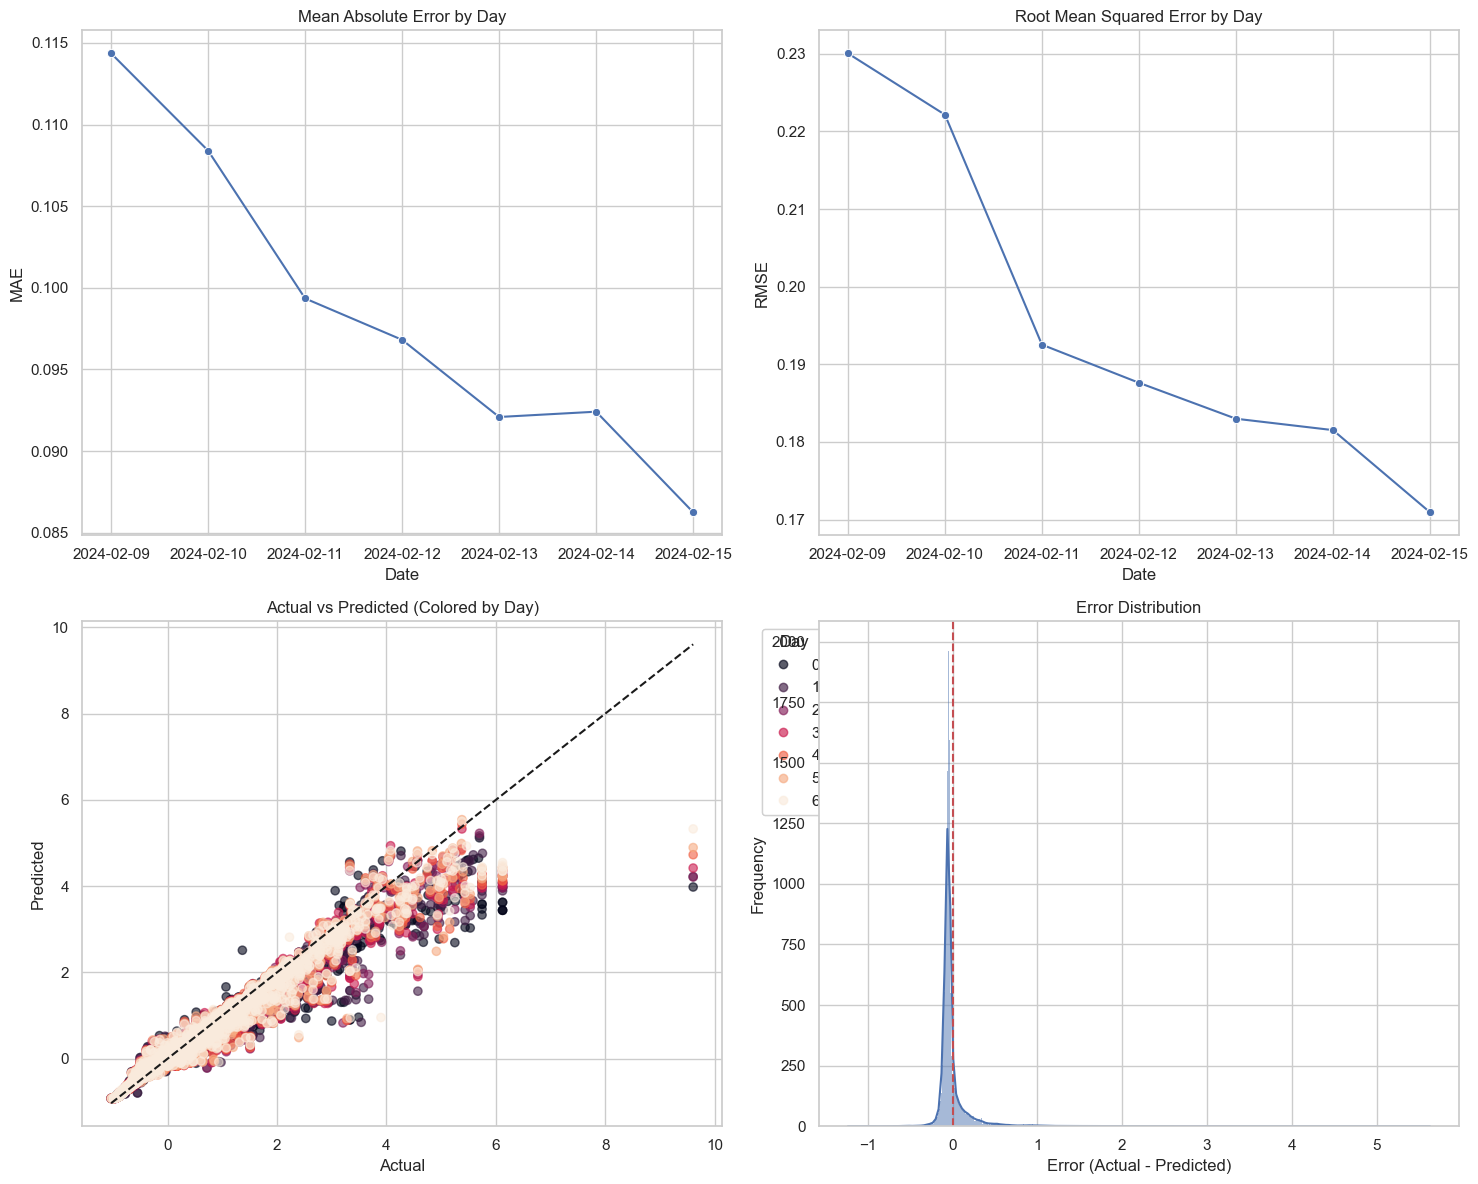

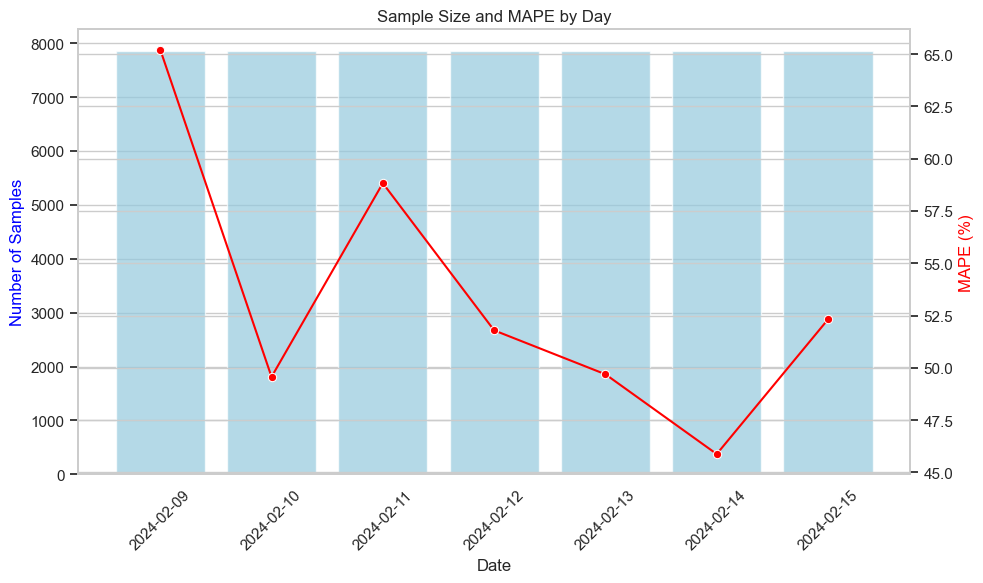

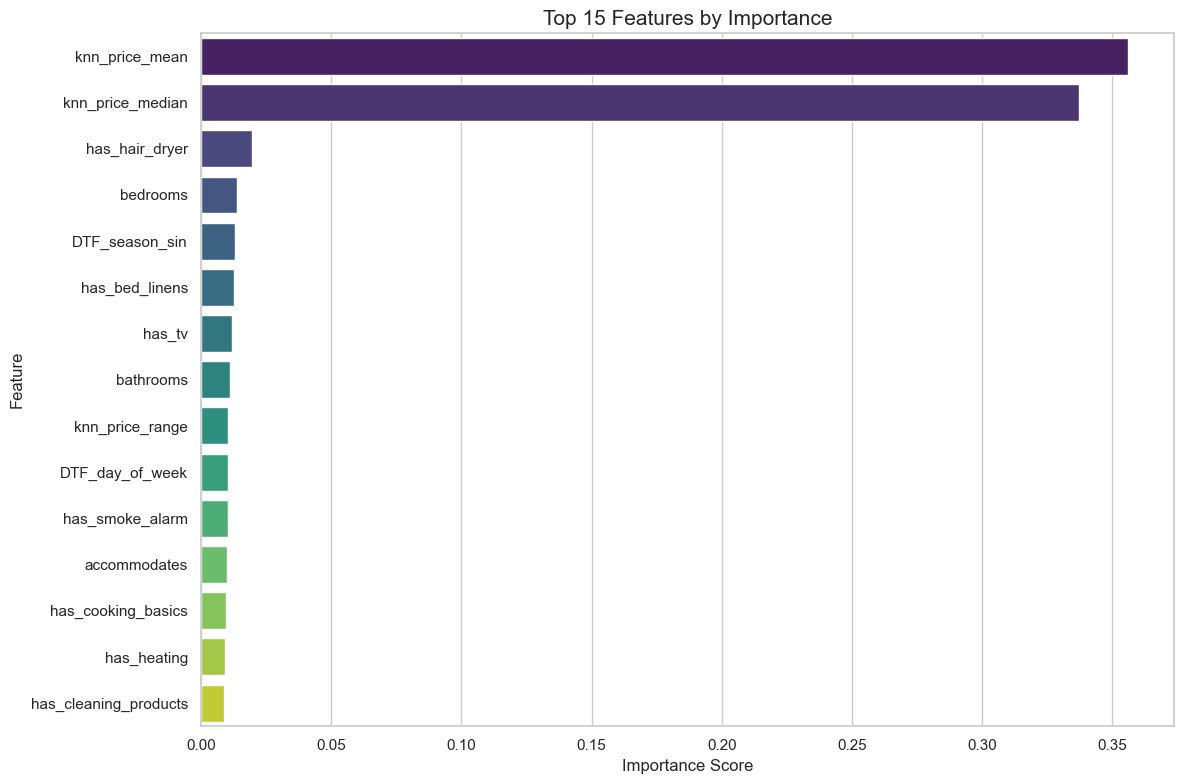

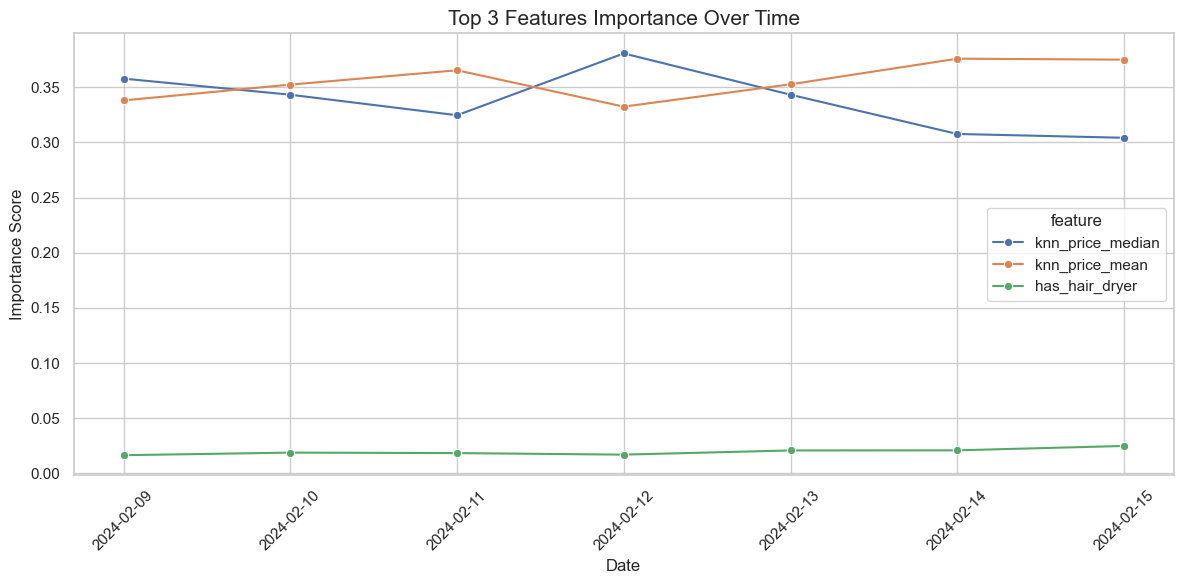

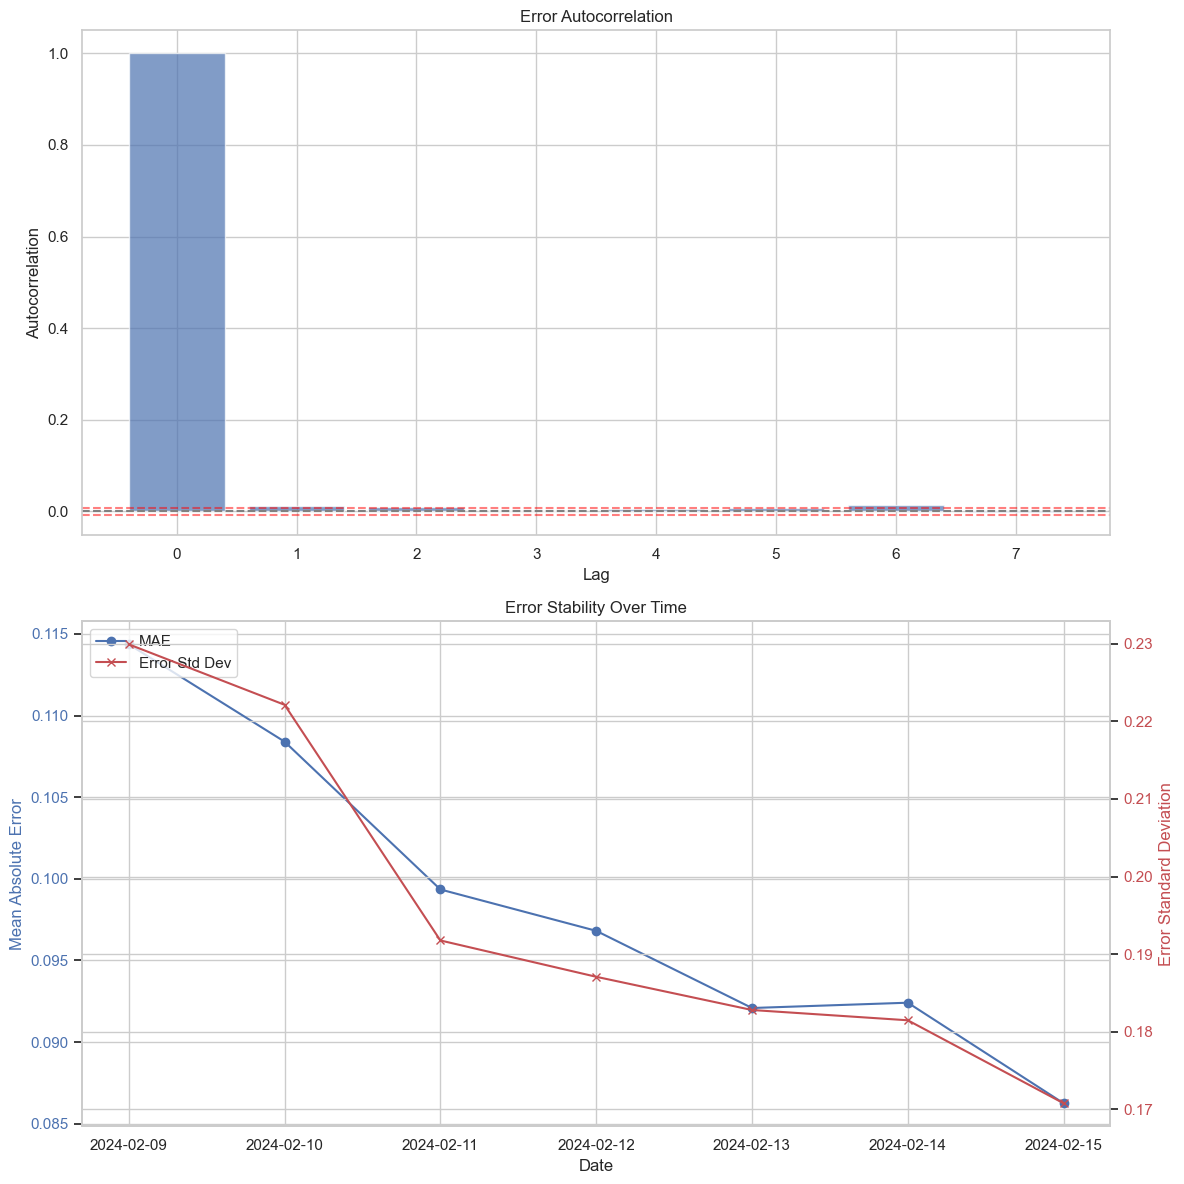

In [4]:
def plot_feature_importance(feature_importance):
    """Plot the top features by importance"""
    # Calculate average importance across all days
    avg_importance = feature_importance.groupby('feature')['importance'].mean().reset_index()
    top_features = avg_importance.sort_values('importance', ascending=False).head(15)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
    plt.title('Top 15 Features by Importance', fontsize=15)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Plot how top 3 features' importance changes over time
    top3_features = top_features.head(3)['feature'].tolist()
    time_data = feature_importance[feature_importance['feature'].isin(top3_features)]
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=time_data, 
        x='date', 
        y='importance',
        hue='feature', 
        marker='o'
    )
    plt.title('Top 3 Features Importance Over Time', fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Importance Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_error_analysis(evaluation_results):
    """Plot error autocorrelation and stability metrics"""
    all_results = evaluation_results['all_results']
    error_stability = evaluation_results['error_stability']
    
    # Set up figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot error autocorrelation
    error_acf = acf(all_results['error'].values, nlags=7)
    lags = range(len(error_acf))
    
    axes[0].bar(lags, error_acf, alpha=0.7)
    axes[0].axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    axes[0].axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    axes[0].axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title('Error Autocorrelation')
    
    # Plot error stability (daily MAE and error std dev)
    daily_mae = error_stability['daily_mae']
    daily_error_std = error_stability['daily_error_std']
    
    ax1 = axes[1]
    ax2 = ax1.twinx()
    
    # Plot MAE
    ax1.plot(daily_mae.index, daily_mae.values, 'b-', marker='o', label='MAE')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean Absolute Error', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    # Plot error std dev
    ax2.plot(daily_error_std.index, daily_error_std.values, 'r-', marker='x', label='Error Std Dev')
    ax2.set_ylabel('Error Standard Deviation', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    axes[1].set_title('Error Stability Over Time')
    
    plt.tight_layout()
    plt.show()

def print_summary(evaluation_results):
    """Print a summary of performance"""
    overall = evaluation_results['overall_metrics']
    daily = evaluation_results['daily_metrics']
    error_autocorr = evaluation_results['error_autocorrelation']
    error_stability = evaluation_results['error_stability']
    
    print("\n===== NEW LISTING MODEL EVALUATION (NO PRICE HISTORY) =====")
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    
    print("\n=== Daily Performance ===")
    print(daily[['date', 'rmse', 'mae', 'mape', 'n_samples']].to_string(index=False))
    
    print("\n=== Performance Statistics ===")
    print("MAE:")
    print(f"  Average: {daily['mae'].mean():.4f}")
    print(f"  Min: {daily['mae'].min():.4f} (Day: {daily.loc[daily['mae'].idxmin(), 'date']})")
    print(f"  Max: {daily['mae'].max():.4f} (Day: {daily.loc[daily['mae'].idxmax(), 'date']})")
    
    print("\nRMSE:")
    print(f"  Average: {daily['rmse'].mean():.4f}")
    print(f"  Min: {daily['rmse'].min():.4f} (Day: {daily.loc[daily['rmse'].idxmin(), 'date']})")
    print(f"  Max: {daily['rmse'].max():.4f} (Day: {daily.loc[daily['rmse'].idxmax(), 'date']})")
    
    print("\nMAPE:")
    print(f"  Average: {daily['mape'].mean():.2f}%")
    print(f"  Min: {daily['mape'].min():.2f}% (Day: {daily.loc[daily['mape'].idxmin(), 'date']})")
    print(f"  Max: {daily['mape'].max():.2f}% (Day: {daily.loc[daily['mape'].idxmax(), 'date']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    print("\n=== Error Stability ===")
    print(f"  MAE Stability Coefficient: {error_stability['mae_stability_coefficient']:.4f}")
    print("  (Lower values indicate more consistent predictions across days)")
    
    # Print top features if available
    if 'feature_importance' in evaluation_results:
        feature_importance = evaluation_results['feature_importance']
        avg_importance = feature_importance.groupby('feature')['importance'].mean().reset_index()
        top_features = avg_importance.sort_values('importance', ascending=False).head(10)
        
        print("\n=== Top 10 Features ===")
        for i, (_, row) in enumerate(top_features.iterrows(), 1):
            print(f"  {i}. {row['feature']}: {row['importance']:.6f}")

def compare_with_price_history_model(new_listing_results, price_history_results):
    """Compare performance of new listing model vs price history model"""
    new_metrics = new_listing_results['overall_metrics']
    history_metrics = price_history_results['overall_metrics']
    
    metrics_to_compare = ['rmse', 'mae', 'r2', 'mape']
    
    print("\n===== MODEL COMPARISON: NEW LISTINGS vs PRICE HISTORY =====")
    print(f"{'Metric':<10} {'New Listing':<15} {'Price History':<15} {'Difference':<15} {'% Difference':<15}")
    print("="*70)
    
    for metric in metrics_to_compare:
        new_val = new_metrics[metric]
        history_val = history_metrics[metric]
        diff = new_val - history_val
        
        # For R², higher is better, so flip the sign
        if metric == 'r2':
            pct_diff = (diff / history_val) * -100
        else:
            pct_diff = (diff / history_val) * 100
        
        print(f"{metric:<10} {new_val:<15.4f} {history_val:<15.4f} {diff:<15.4f} {pct_diff:<15.2f}%")
    
    # Compare daily performance
    new_daily = new_listing_results['daily_metrics']
    history_daily = price_history_results['daily_metrics']
    
    # Ensure we have matching dates for comparison
    merged_daily = pd.merge(
        new_daily, 
        history_daily,
        on='date', 
        suffixes=('_new', '_history')
    )
    
    if not merged_daily.empty:
        print("\n=== Day-by-Day Comparison ===")
        for i, row in merged_daily.iterrows():
            print(f"Date: {row['date']}")
            print(f"  MAE (New): {row['mae_new']:.4f}, MAE (History): {row['mae_history']:.4f}, Diff: {row['mae_new'] - row['mae_history']:.4f}")
            print(f"  RMSE (New): {row['rmse_new']:.4f}, RMSE (History): {row['rmse_history']:.4f}, Diff: {row['rmse_new'] - row['rmse_history']:.4f}")
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    
    if not merged_daily.empty:
        plt.plot(
            merged_daily['date'], 
            merged_daily['mae_new'], 
            'b-', 
            marker='o', 
            label='New Listing Model'
        )
        plt.plot(
            merged_daily['date'], 
            merged_daily['mae_history'], 
            'r-', 
            marker='x', 
            label='Price History Model'
        )
        
        plt.title('MAE Comparison: New Listing vs Price History Model')
        plt.xlabel('Date')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    import os
    
    # Paths
    train_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train.csv"
    test_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\test_feb.csv"
    output_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\NewListings"
    output_path = os.path.join(output_dir, "new_listing_results.csv")
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Run the model for 7 days prediction
    results = run_day_by_day_new_listing_prediction(
        train_path=train_path,
        test_path=test_path,
        prediction_days=7,
        output_path=output_path
    )
    
    # Print summary and plot results
    print_summary(results)
    plot_results(results)
    plot_feature_importance(results['feature_importance'])
    plot_error_analysis(results)
    
    # If you have results from a price history model for comparison
    # price_history_results_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\NN\strap_results.csv"
    # if os.path.exists(price_history_results_path):
    #     price_history_results = load_results(price_history_results_path)
    #     compare_with_price_history_model(results, price_history_results)